In [1]:
import pandas
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import sys
from PIL import Image

def reload_functions(path):
  if 'ShoesClassification' in sys.modules:
    del sys.modules['ShoesClassification']
  functions_path = path + 'IC_functions.py'
  !cp $functions_path .

## 1. Data

### 1.1 Loading and Preprocessing the data

In [3]:
import glob

path = ''
train_data = np.zeros([112, 3, 2, 224, 224, 3])
test_m_data  = np.zeros([10, 3, 2, 224, 224, 3])
test_w_data  = np.zeros([10, 3, 2, 224, 224, 3])
train_data_dic = {}
test_m_data_dic  = {}
test_w_data_dic  = {}

for dic, path, mat in zip([train_data_dic, test_w_data_dic, test_m_data_dic],
                           [path + "data/train/*.jpg", path + "data/test_w/*.jpg", path + "data/test_m/*.jpg"],
                           [train_data, test_m_data, test_w_data]):
  for file in glob.glob(path):
    filename = file.split("/")[-1]            # get the name of the .jpg file
    img = np.asarray(Image.open(file))        # read the image as a numpy array
    
    # remove the alpha channel, normalize and subtract by 0.5:
    dic[filename] = (img[:, :, :3] / 255) - 0.5

  Images = sorted([(key, value) for key, value in dic.items()])
  Images = [value[1] for value in Images]
  for num_of_t in range(mat.shape[0]):
    for num_in_t in range(3):
      for direction in range(2):
        mat[num_of_t, num_in_t, direction] = Images[num_of_t*6 + num_in_t*2 + direction]

index = 9*train_data.shape[0]//10
valid_data = train_data[index:]
train_data = train_data[:index]

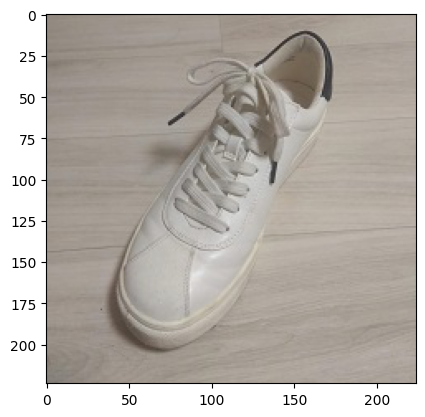

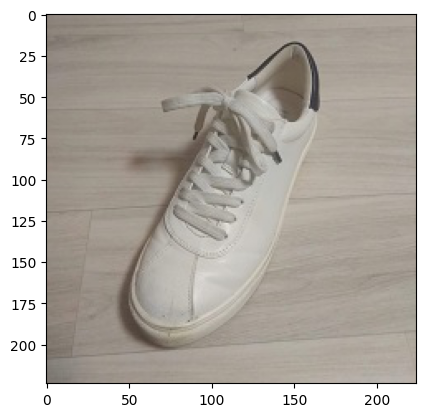

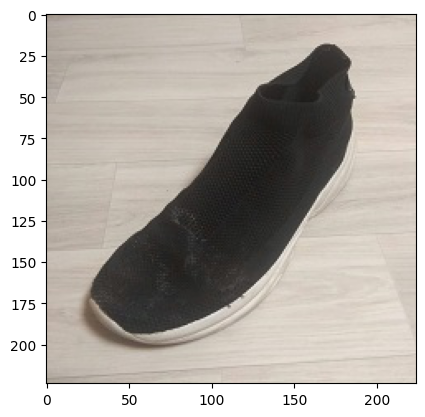

In [4]:
test1 = np.load(path+"data/preproccessing_validation/preproccessing_validation_test1.npy")
test2 = np.load(path+"data/preproccessing_validation/preproccessing_validation_test2.npy")
test3 = np.load(path+"data/preproccessing_validation/preproccessing_validation_test3.npy")
if (test1 != train_data[4,0,0,:,:,:]).any() or \
   (test2 != train_data[4,0,1,:,:,:]).any() or \
   (test3 != train_data[4,1,1,:,:,:]).any():
   print("preprocessing error, make sure you followed all instructions carefully")

plt.figure()
plt.imshow(train_data[4,0,0,:,:,:]+0.5) # left shoe of first pair submitted by 5th student
plt.figure()
plt.imshow(train_data[4,0,1,:,:,:]+0.5) # right shoe of first pair submitted by 5th student
plt.figure()
plt.imshow(train_data[4,1,1,:,:,:]+0.5) # right shoe of second pair submitted by 5th student


### 1.2 Generating Same Pairs

(100, 3, 2, 224, 224, 3)
(300, 448, 224, 3)


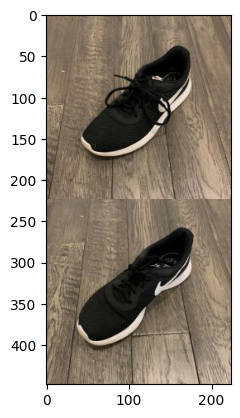

In [5]:
def generate_same_pair(data):
  result = np.zeros((data.shape[0]*3, 448, 224, 3))
  for index in range(data.shape[0]*3):
    result[index] = np.vstack((data[index//3, index % 3, 0],
                               data[index//3, index % 3, 1]))
  return result

print(train_data.shape) # if this is [N, 3, 2, 224, 224, 3]
print(generate_same_pair(train_data).shape) # should be [N*3, 448, 224, 3]
plt.imshow(generate_same_pair(train_data)[0]+0.5) # should show 2 shoes from the same pair

### 1.3 Generate Different Pairs

(100, 3, 2, 224, 224, 3)
(300, 448, 224, 3)


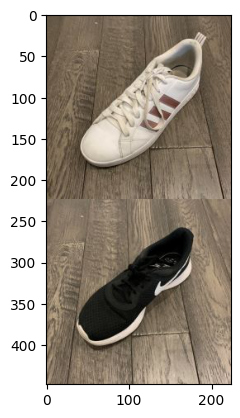

In [6]:
def generate_different_pair(data):
  result = np.zeros((data.shape[0]*3, 448, 224, 3))
  for index in range(data.shape[0]*3):
    result[index] = np.vstack((data[index//3, (index + 1) % 3, 0],
                               data[index//3, index % 3, 1]))
  return result

print(train_data.shape) # if this is [N, 3, 2, 224, 224, 3]
print(generate_different_pair(train_data).shape) # should be [N*3, 448, 224, 3]
plt.imshow(generate_different_pair(train_data)[0]+0.5) # should show 2 shoes from different pairs

## 2. Convolutional Neural Networks

In [7]:
def get_accuracy(model, data, batch_size=50,device='cpu'):
    """This function returns two
    separate values: the model accuracy on the positive samples,
    and the model accuracy on the negative samples.

    Example Usage:

    >>> model = CNN() # create untrained model
    >>> pos_acc, neg_acc= get_accuracy(model, valid_data)
    >>> false_positive = 1 - pos_acc
    >>> false_negative = 1 - neg_acc
    """

    model.eval()
    n = data.shape[0]

    data_pos = generate_same_pair(data)      # should have shape [n * 3, 448, 224, 3]
    data_neg = generate_different_pair(data) # should have shape [n * 3, 448, 224, 3]

    pos_correct = 0
    for i in range(0, len(data_pos), batch_size):
        xs = torch.Tensor(data_pos[i:i+batch_size]).permute(0,3,1,2)
        xs = xs.to(device)
        zs = model(xs)
        pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
        pred = pred.detach().cpu().numpy()
        pos_correct += (pred == 1).sum()

    neg_correct = 0
    for i in range(0, len(data_neg), batch_size):
        xs = torch.Tensor(data_neg[i:i+batch_size]).permute(0,3,1,2)
        xs = xs.to(device)
        zs = model(xs)
        pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
        pred = pred.detach().cpu().numpy()
        neg_correct += (pred == 0).sum()

    return pos_correct / (n * 3), neg_correct / (n * 3)

## 3. Training

### 3.1 train model

In [8]:
from pickle import NONE
import time

def train_model(model,
                train_data=train_data,
                validation_data=valid_data,
                batch_size=25,
                learning_rate=0.001,
                weight_decay=0,
                epochs=20,
                checkpoint_path= path + "checkpoint-"):

  start_time = time.time()
  # Initialize Loss function and optimizer
  criterion = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                               weight_decay=weight_decay)

  valid_accuracy = []
  train_accuracy = []
  loss_accuracy = []

  # Create the positive and negative pairs
  same = generate_same_pair(train_data)
  different = generate_different_pair(train_data)

  for epoch in range(1, epochs + 1):
    # shuffle the positive and negative pairs
    np.random.shuffle(same)
    np.random.shuffle(different)

    for i in range(0, same.shape[0], batch_size//2):
      if same.shape[0] - i < batch_size//2:
        break
      # sample batch_size//2 of positive pairs and batch_size//2 of negative pairs
      sample_same = same[i: i + batch_size//2]
      sample_different = different[i: i + batch_size//2]

      # Create the labels of the batch and combine the positive and negative half batches
      sample = np.vstack((sample_same, sample_different))
      labels = np.reshape(np.vstack((np.ones(batch_size//2), np.zeros(batch_size//2))), (batch_size//2)*2)

      # Conversion from numpy array to torch tensor (if working with gpu also change device to gpu)
      sample = torch.Tensor(sample).transpose(1, 3).transpose(2, 3)
      labels = torch.Tensor(labels).long()

      model.train()
      optimizer.zero_grad() # Reset the optimizer
      output = model(sample) # Predict output
      loss = criterion(output, labels) # Compute the loss
      loss.backward() # Backward pass
      optimizer.step() # Update the parameters

    # track the accuracy and loss of the training and validation
    loss_accuracy.append(loss.item() / batch_size)
    valid_accuracy.append(get_accuracy(model, valid_data, batch_size=batch_size))
    train_accuracy.append(get_accuracy(model, train_data, batch_size=batch_size))

    # printing Epoch result
    print(f"Epoch {epoch}:")
    print(f"Loss function result: {loss / batch_size}")
    print(f"Training Accuracy - Positive: {train_accuracy[-1][0]}, Negative: {train_accuracy[-1][1]}")
    print(f"Validation Accuracy - Positive: {valid_accuracy[-1][0]}, Negative: {valid_accuracy[-1][1]}")


    # checkpoint the model -- In order not to overwrite the correct values we saved
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'avg_accuracy': sum(train_accuracy[-1])/2
            }, checkpoint_path + str(epoch) + '.pt')


  plt.figure(figsize=(8, 6))
  plt.plot(range(1, epoch+1), loss_accuracy, '-', color='red', label='Loss accuracy')
  plt.plot(range(1, epoch+1), np.array(train_accuracy)[:,0], '-', color='blue', label='Train positive accuracy')
  plt.plot(range(1, epoch+1), np.array(train_accuracy)[:,1], '--', color='blue', label='Train negative accuracy')
  plt.plot(range(1, epoch+1), np.array(valid_accuracy)[:,0], '-', color='green', label='Valid positive accuracy')
  plt.plot(range(1, epoch+1), np.array(valid_accuracy)[:,1], '--', color='green', label='Valid negative accuracy')
  plt.title('Training, Validation and Loss accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.grid(True)

  '''
  # In order not to overwrite the correct values we saved
  plt.savefig(path + f"n = 16, kernel size = 5, learning rate = {learning_rate}, batch size = {batch_size}.png")
  with open(path + 'readme.txt', 'a') as f:
    f.write(f"{checkpoint_path} learning rate = {learning_rate}, batch size = {batch_size}, time =  {time.time() - start_time} seconds" + '\n'
            + f"Final Loss function Accuracy - {loss_accuracy[-1]}" + '\n'
            + f"Final Training Accuracy - Positive: {train_accuracy[-1][0]}, Negative: {train_accuracy[-1][1]}" + '\n'
            + f"Final Validation Accuracy - Positive: {valid_accuracy[-1][0]}, Negative: {valid_accuracy[-1][1]}" + '\n\n')
  '''
  plt.show()

  t = [sum(x) for x in train_accuracy]
  v = [sum(x) for x in valid_accuracy] #[sum(x) for x in valid_accuracy]
  avg_accuracy = np.sum(np.array((t, v)), axis=0)

  epoch_max = np.argmax(avg_accuracy) + 1
  print(f'epoch with max train accuracy: {epoch_max}, avg accuracy: {avg_accuracy[epoch_max-1]/4}')

  return epoch_max


### 3.2 Sanity check

Epoch 1:
Loss function result: 0.02312237024307251
Training Accuracy - Positive: 0.0, Negative: 1.0
Validation Accuracy - Positive: 0.0, Negative: 1.0
Epoch 2:
Loss function result: 0.02311098761856556
Training Accuracy - Positive: 1.0, Negative: 0.0
Validation Accuracy - Positive: 1.0, Negative: 0.0
Epoch 3:
Loss function result: 0.02314436249434948
Training Accuracy - Positive: 1.0, Negative: 0.0
Validation Accuracy - Positive: 1.0, Negative: 0.0
Epoch 4:
Loss function result: 0.023101557046175003
Training Accuracy - Positive: 1.0, Negative: 0.0
Validation Accuracy - Positive: 1.0, Negative: 0.0
Epoch 5:
Loss function result: 0.023095261305570602
Training Accuracy - Positive: 0.0, Negative: 1.0
Validation Accuracy - Positive: 0.0, Negative: 1.0
Epoch 6:
Loss function result: 0.023146096616983414
Training Accuracy - Positive: 0.0, Negative: 1.0
Validation Accuracy - Positive: 0.0, Negative: 1.0
Epoch 7:
Loss function result: 0.02312440238893032
Training Accuracy - Positive: 0.2, Negat

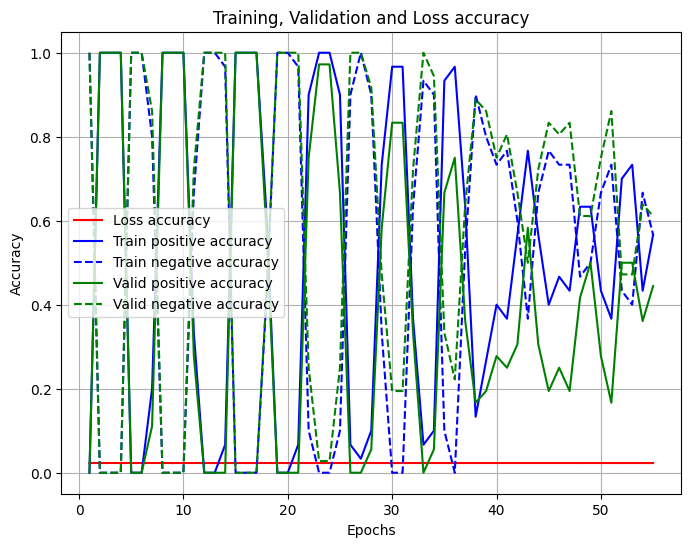

Final Training Accuracy - Positive: 0.5666666666666667, Negative: 0.5666666666666667
Final Validation Accuracy - Positive: 0.4444444444444444, Negative: 0.6111111111111112
epoch with max accuracy: 44, avg accuracy: 0.6166666666666667
Epoch 1:
Loss function result: 0.027756843715906143
Training Accuracy - Positive: 0.1, Negative: 0.8666666666666667
Validation Accuracy - Positive: 0.0, Negative: 1.0
Epoch 2:
Loss function result: 0.02773260325193405
Training Accuracy - Positive: 0.8, Negative: 0.2
Validation Accuracy - Positive: 0.75, Negative: 0.3888888888888889
Epoch 3:
Loss function result: 0.027704454958438873
Training Accuracy - Positive: 0.1, Negative: 0.9
Validation Accuracy - Positive: 0.0, Negative: 1.0
Epoch 4:
Loss function result: 0.027821872383356094
Training Accuracy - Positive: 0.8, Negative: 0.26666666666666666
Validation Accuracy - Positive: 0.7222222222222222, Negative: 0.3611111111111111
Epoch 5:
Loss function result: 0.02733835205435753
Training Accuracy - Positive: 0

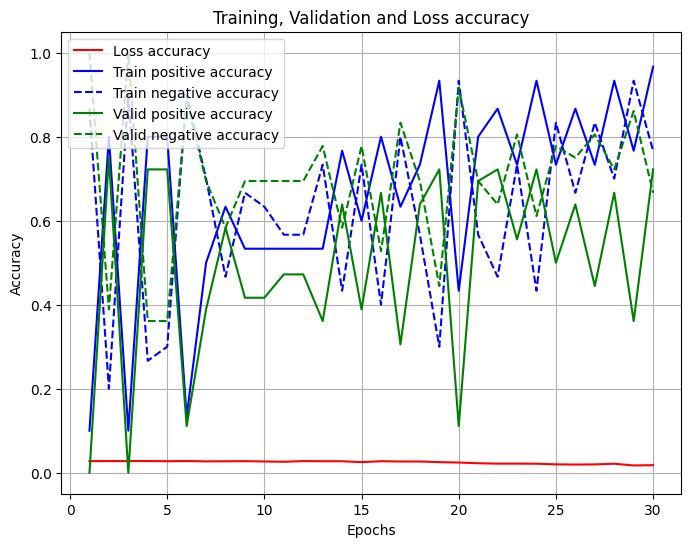

Final Training Accuracy - Positive: 0.9666666666666667, Negative: 0.7666666666666667
Final Validation Accuracy - Positive: 0.7222222222222222, Negative: 0.6666666666666666
epoch with max accuracy: 30, avg accuracy: 0.8666666666666667


In [ ]:
reload_functions(path)
import IC_functions
CNN_epoch = train_model(model=IC_functions.CNN(),
                                train_data=train_data[:10],
                                validation_data=valid_data,
                                batch_size=30,
                                learning_rate=0.0005,
                                weight_decay=0,
                                epochs=55,
                                checkpoint_path=path + 'CNN_checkpoint-')
CNNChannel_epoch = train_model(model=IC_functions.CNNChannel(),
                                train_data=train_data[:10],
                                validation_data=valid_data,
                                batch_size=25,
                                learning_rate=0.001,
                                weight_decay=0,
                                epochs=30,
                                checkpoint_path=path + 'CNNChannel_checkpoint-')


### 3.3 training and saving the optimal model

Epoch 1:
Loss function result: 0.01736380159854889
Training Accuracy - Positive: 0.43, Negative: 0.5933333333333334
Validation Accuracy - Positive: 0.3888888888888889, Negative: 0.6666666666666666
Epoch 2:
Loss function result: 0.017347654327750206
Training Accuracy - Positive: 0.0, Negative: 1.0
Validation Accuracy - Positive: 0.0, Negative: 1.0
Epoch 3:
Loss function result: 0.01733699068427086
Training Accuracy - Positive: 0.0, Negative: 1.0
Validation Accuracy - Positive: 0.0, Negative: 1.0
Epoch 4:
Loss function result: 0.01734866201877594
Training Accuracy - Positive: 0.9933333333333333, Negative: 0.0
Validation Accuracy - Positive: 0.9722222222222222, Negative: 0.027777777777777776
Epoch 5:
Loss function result: 0.017331736162304878
Training Accuracy - Positive: 0.8433333333333334, Negative: 0.16666666666666666
Validation Accuracy - Positive: 0.8055555555555556, Negative: 0.25
Epoch 6:
Loss function result: 0.017329104244709015
Training Accuracy - Positive: 0.87, Negative: 0.15


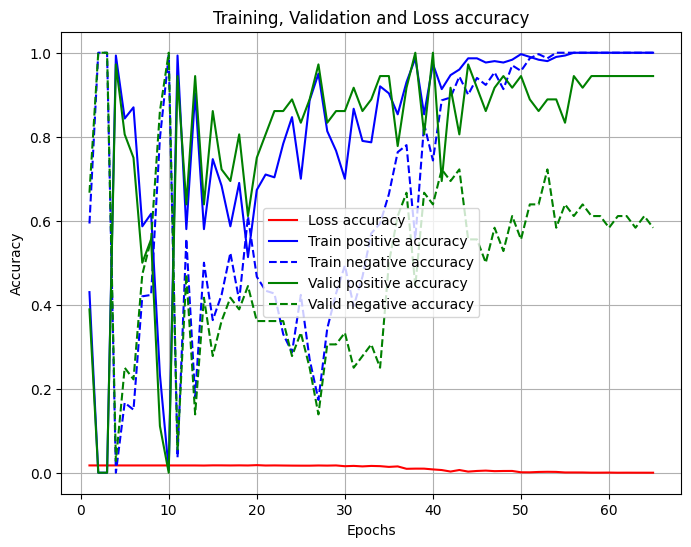

epoch with max train accuracy: 53, avg accuracy: 0.8944444444444445
Epoch 1:
Loss function result: 0.02783152274787426
Training Accuracy - Positive: 0.98, Negative: 0.01
Validation Accuracy - Positive: 1.0, Negative: 0.0
Epoch 2:
Loss function result: 0.027634918689727783
Training Accuracy - Positive: 0.4633333333333333, Negative: 0.72
Validation Accuracy - Positive: 0.4166666666666667, Negative: 0.8055555555555556
Epoch 3:
Loss function result: 0.025365913286805153
Training Accuracy - Positive: 0.7433333333333333, Negative: 0.6433333333333333
Validation Accuracy - Positive: 0.8055555555555556, Negative: 0.6388888888888888
Epoch 4:
Loss function result: 0.015376133844256401
Training Accuracy - Positive: 0.8933333333333333, Negative: 0.6133333333333333
Validation Accuracy - Positive: 0.8888888888888888, Negative: 0.6944444444444444
Epoch 5:
Loss function result: 0.01892312616109848
Training Accuracy - Positive: 0.9433333333333334, Negative: 0.5666666666666667
Validation Accuracy - Posit

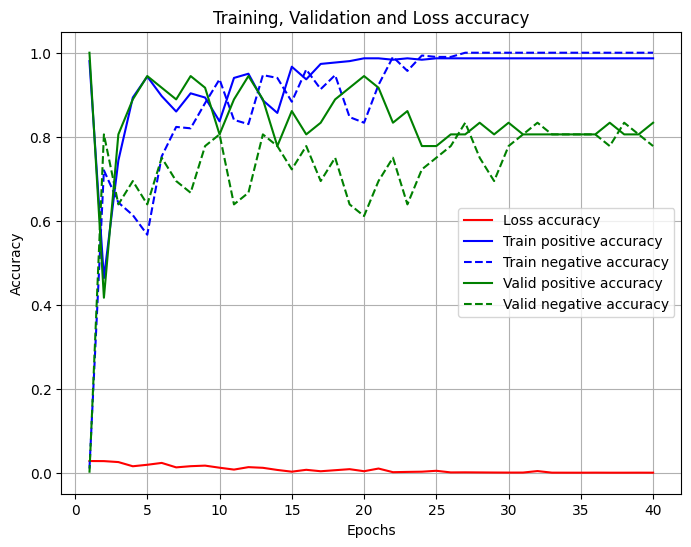

epoch with max train accuracy: 27, avg accuracy: 0.9063888888888889


In [ ]:
reload_functions(path)
import IC_functions
CNN_model = IC_functions.CNN() 
CNNChannel_model = IC_functions.CNNChannel()

CNN_epoch = train_model(model=IC_functions.CNN(),
                                train_data=train_data,
                                validation_data=valid_data,
                                batch_size=40,
                                learning_rate=0.0005,
                                weight_decay=0,
                                epochs=65,
                                checkpoint_path=path + 'CNN_checkpoint-')
CNNChannel_epoch = train_model(model=IC_functions.CNNChannel(),
                                train_data=train_data,
                                validation_data=valid_data,
                                batch_size=25,
                                learning_rate=0.001,
                                weight_decay=0,
                                epochs=40,
                                checkpoint_path=path + 'CNNChannel_checkpoint-')


In [ ]:
reload_functions(path)
import IC_functions
CNN_model = IC_functions.CNN() 
CNNChannel_model = IC_functions.CNNChannel() 

'''
checkpoint_CNNChannel = torch.load(path+f'CNNChannel_checkpoint-{CNNChannel_epoch}.pt')
checkpoint_CNN = torch.load(path+f'CNN_checkpoint-{CNN_epoch}.pt')
'''

checkpoint_CNNChannel = torch.load(path + 'MY_checkpoints/CNNChannel_checkpoint-30.pt')
checkpoint_CNN = torch.load(path+'MY_checkpoints/CNN_checkpoint-50.pt')

CNNChannel_model.load_state_dict(checkpoint_CNNChannel['model_state_dict'])
CNN_model.load_state_dict(checkpoint_CNN['model_state_dict'])

checkpoint_path  = path+"checkpoints/" 
torch.save(CNN_model.state_dict(), checkpoint_path+"best_CNN_model.pk") 
torch.save(CNNChannel_model.state_dict(), checkpoint_path+"best_CNNChannel_model.pk") 

## 4. Testing

### 4.1. Accuracies

In [11]:
reload_functions(path)
import IC_functions
CNN_model = IC_functions.CNN()
CNNChannel_model = IC_functions.CNNChannel()
checkpoint_path  = path+"checkpoints/"

CNN_model.load_state_dict(torch.load(checkpoint_path+"best_CNN_model.pk"))
CNN_model.eval()
CNNChannel_model.load_state_dict(torch.load(checkpoint_path+"best_CNNChannel_model.pk"))
CNNChannel_model.eval()
print(f"CNNChannel Men's accuracy: {get_accuracy(CNNChannel_model, test_m_data, batch_size=25)}")
print(f"CNNChannel Women's accuracy: {get_accuracy(CNNChannel_model, test_w_data, batch_size=25)}")
print(f"CNN Men's accuracy: {get_accuracy(CNN_model, test_m_data, batch_size=25)}")
print(f"CNN Women's accuracy: {get_accuracy(CNN_model, test_w_data, batch_size=25)}")


CNNChannel Men's accuracy: (0.9333333333333333, 0.9)
CNNChannel Women's accuracy: (0.8333333333333334, 0.9)
CNN Men's accuracy: (0.9666666666666667, 0.7)
CNN Women's accuracy: (0.8333333333333334, 0.6666666666666666)


### 4.2 Men's Shoes example

tensor([1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1])


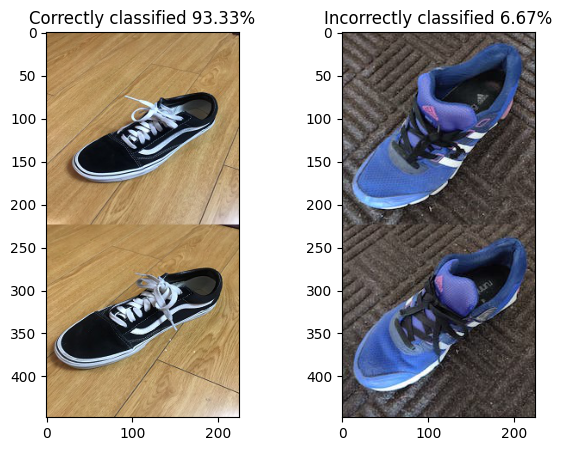

In [12]:
# Create the positive and negative pairs
same = generate_same_pair(test_m_data)
same_to_predict = np.transpose(same, (0, 3, 1, 2))

correct_shown, incorrect_shown = False, False

sample = torch.Tensor(same_to_predict)
with torch.no_grad():
  sample_prediction = CNNChannel_model(sample)
sample_prediction = torch.argmax(sample_prediction, dim=1)
print(sample_prediction)

# display correctly classified:
correct_img, incorrect_img = np.ones((448,224,3)), np.ones((448,224,3))

for img in range(sample_prediction.shape[0]):
  if not correct_shown:
    if sample_prediction[img]:
      correct_img = same[img] + 0.5
  if not incorrect_shown:
    if not sample_prediction[img]:
      incorrect_img = same[img] + 0.5
  if correct_shown and incorrect_shown:
    break

percent = float(sum(sample_prediction)*100/sample_prediction.shape[0])
plt.figure(figsize=(7, 5))

plt.subplot(1, 2, 1)  # first image
plt.imshow(correct_img)
plt.title(f'Correctly classified {round(percent, 2)}%')

plt.subplot(1, 2, 2)  # second image
plt.imshow(incorrect_img)
plt.title(f'Incorrectly classified {round(100-percent, 2)}%')
plt.show()

tensor([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
        1, 1, 0, 1, 1, 1])


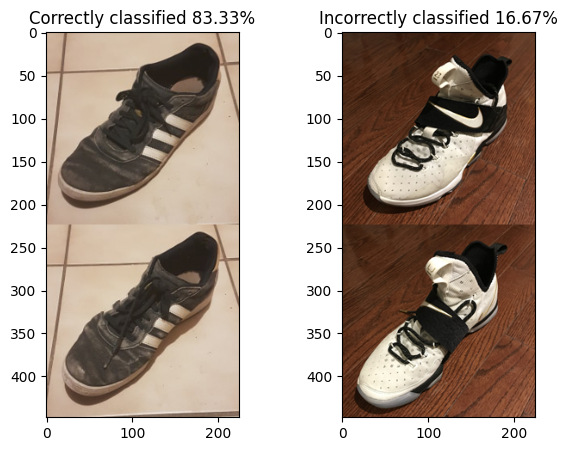

In [13]:
# Create the positive and negative pairs
same = generate_same_pair(test_w_data)
same_to_predict = np.transpose(same, (0, 3, 1, 2))

correct_shown, incorrect_shown = False, False

sample = torch.Tensor(same_to_predict)
with torch.no_grad():
  sample_prediction = CNNChannel_model(sample)
sample_prediction = torch.argmax(sample_prediction, dim=1)
print(sample_prediction)

# display correctly classified:
correct_img, incorrect_img = np.ones((448,224,3)), np.ones((448,224,3))

for img in range(sample_prediction.shape[0]):
  if not correct_shown:
    if sample_prediction[img]:
      correct_img = same[img] + 0.5
  if not incorrect_shown:
    if not sample_prediction[img]:
      incorrect_img = same[img] + 0.5
  if correct_shown and incorrect_shown:
    break

percent = float(sum(sample_prediction)*100/sample_prediction.shape[0])
plt.figure(figsize=(7, 5))

plt.subplot(1, 2, 1)
plt.imshow(correct_img)
plt.title(f'Correctly classified {round(percent, 2)}%')

plt.subplot(1, 2, 2)
plt.imshow(incorrect_img)
plt.title(f'Incorrectly classified {round(100-percent, 2)}%')
plt.show()